In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, PoissonRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as preprocessing 

import regressionUtils as rg


In [2]:
county_df = pd.read_pickle("../Data/county_data_totals.pkl")
county_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3087 entries, 1001.0 to 56045.0
Data columns (total 65 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   Population estimates, July 1, 2019,  (V2019)                                            3087 non-null   float64
 1   Population estimates base, April 1, 2010,  (V2019)                                      3087 non-null   float64
 2   Population, percent change - April 1, 2010 (estimates base) to July 1, 2019,  (V2019)   3087 non-null   float64
 3   Population, Census, April 1, 2010                                                       3087 non-null   float64
 4   Persons under 5 years, percent                                                          3086 non-null   float64
 5   Persons under 18 years, percent                            

In [3]:
county_df.drop(county_df[county_df['deaths'] == 0].index, inplace = True) 
county_df['Deaths per 100k'] = 1e5*county_df['deaths']/county_df['Population estimates, July 1, 2019,  (V2019)']
pt_boxcox = preprocessing.PowerTransformer(method='box-cox', standardize=False)
county_df['Deaths per 100k, trans'] = pt_boxcox.fit_transform(county_df[['Deaths per 100k']])
# county_df['Deaths per 100k, trans'] = county_df['Deaths per 100k'] # comment this in instead of the above to not do the box cox transform (for plots showing it's use)


In [4]:
county_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3007 entries, 1001.0 to 56045.0
Data columns (total 67 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   Population estimates, July 1, 2019,  (V2019)                                            3007 non-null   float64
 1   Population estimates base, April 1, 2010,  (V2019)                                      3007 non-null   float64
 2   Population, percent change - April 1, 2010 (estimates base) to July 1, 2019,  (V2019)   3007 non-null   float64
 3   Population, Census, April 1, 2010                                                       3007 non-null   float64
 4   Persons under 5 years, percent                                                          3007 non-null   float64
 5   Persons under 18 years, percent                            

In [5]:
# main_features_df = county_df[["Black or African American alone, percent(a)", "Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019", \
#                               "Persons  without health insurance, under age 65 years, percent", "Households with a broadband Internet subscription, percent, 2015-2019", \
#                               "Median value of owner-occupied housing units, 2015-2019", \
#                               "Deaths per 100k, trans"]].dropna()

main_features_df = county_df[[\
#                             no    "Persons under 5 years, percent",\
                              "Persons 65 years and over, percent",\
#                             no    "White alone, percent",\
                                "Black or African American alone, percent(a)",\
#                             no    "Asian alone, percent(a)",\
                                "Two or More Races, percent",\
                                "White alone, not Hispanic or Latino, percent",\
                                "Median value of owner-occupied housing units, 2015-2019",\
#                             no    "Median gross rent, 2015-2019",\
                                "Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019",\
                                "Households with a computer, percent, 2015-2019",\
                                "Households with a broadband Internet subscription, percent, 2015-2019",
                                "High school graduate or higher, percent of persons age 25 years+, 2015-2019",\
                                "Bachelor's degree or higher, percent of persons age 25 years+, 2015-2019",\
                                "Persons  without health insurance, under age 65 years, percent",\
                                "Median household income (in 2019 dollars), 2015-2019",\
                                "Deaths per 100k, trans"]].dropna()





main_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3004 entries, 1001.0 to 56045.0
Data columns (total 13 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Persons 65 years and over, percent                                           3004 non-null   float64
 1   Black or African American alone, percent(a)                                  3004 non-null   float64
 2   Two or More Races, percent                                                   3004 non-null   float64
 3   White alone, not Hispanic or Latino, percent                                 3004 non-null   float64
 4   Median value of owner-occupied housing units, 2015-2019                      3004 non-null   float64
 5   Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019   3004 non-null   float64
 6   Households with a computer, pe

In [6]:
# drop some outliers
main_features_df.drop(main_features_df[main_features_df['Two or More Races, percent'] > 20].index, inplace = True) 
main_features_df.drop(main_features_df[main_features_df['Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019'] < 70].index, inplace = True) 
# no main_features_df.drop(main_features_df[main_features_df['High school graduate or higher, percent of persons age 25 years+, 2015-2019'] < 50].index, inplace = True) 
# no main_features_df.drop(main_features_df[main_features_df['Median value of owner-occupied housing units, 2015-2019'] > 0.8e6].index, inplace = True) 
main_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2988 entries, 1001.0 to 56045.0
Data columns (total 13 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Persons 65 years and over, percent                                           2988 non-null   float64
 1   Black or African American alone, percent(a)                                  2988 non-null   float64
 2   Two or More Races, percent                                                   2988 non-null   float64
 3   White alone, not Hispanic or Latino, percent                                 2988 non-null   float64
 4   Median value of owner-occupied housing units, 2015-2019                      2988 non-null   float64
 5   Living in same house 1 year ago, percent of persons age 1 year+, 2015-2019   2988 non-null   float64
 6   Households with a computer, pe

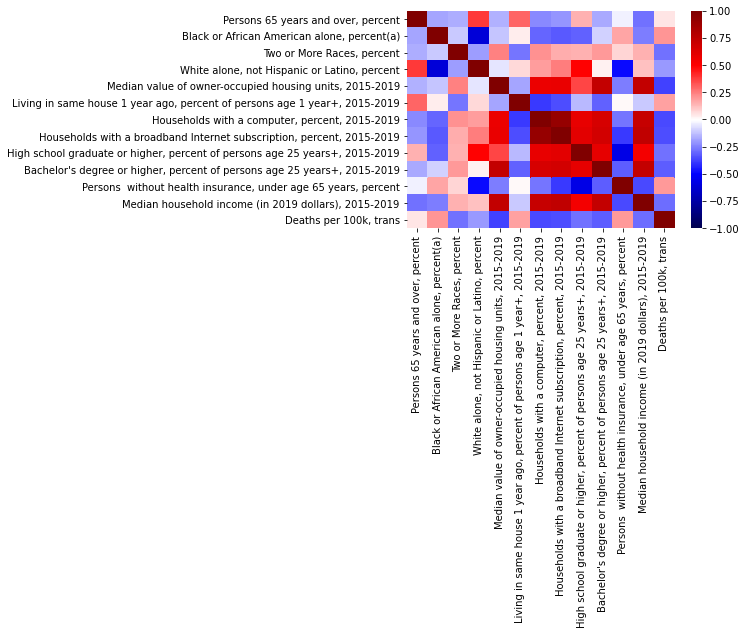

In [7]:
sns.heatmap(main_features_df.corr(), cmap="seismic", vmin=-1, vmax=1);

In [8]:
# pp = sns.pairplot(main_features_df, plot_kws=dict(alpha=.1, edgecolor='none'))
# for ax in pp.axes.flatten():
#     ax.set_xlabel(ax.get_xlabel(), rotation = 5)
#     ax.set_ylabel(ax.get_ylabel(), rotation = 85)
##     ax.yaxis.get_label().set_horizontalalignment('right')    

In [9]:
X, y = main_features_df.drop('Deaths per 100k, trans',axis=1), main_features_df['Deaths per 100k, trans']
input_features = list(X.columns)

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=110) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

Simple regression scores:  [0.241, 0.268, 0.238, 0.289, 0.267] 

Simple mean cv r^2: 0.261 +- 0.019


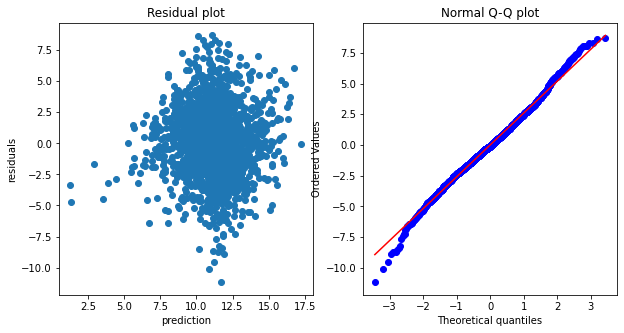

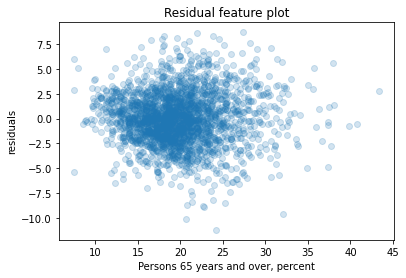

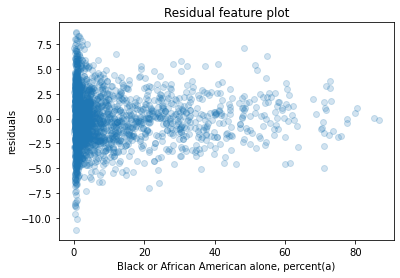

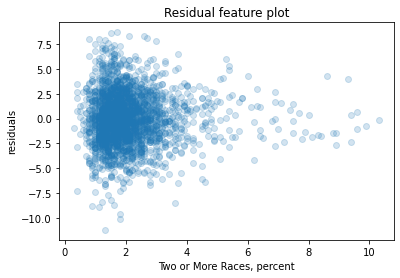

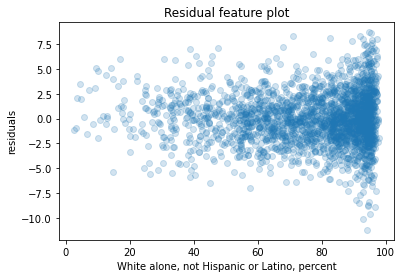

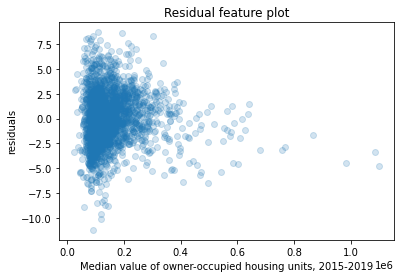

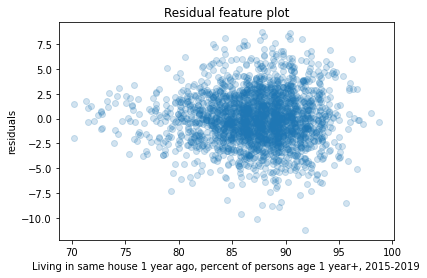

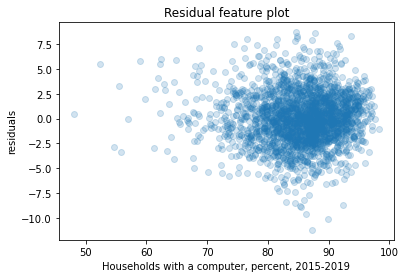

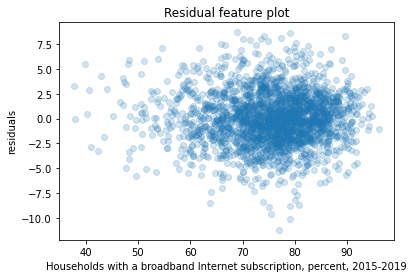

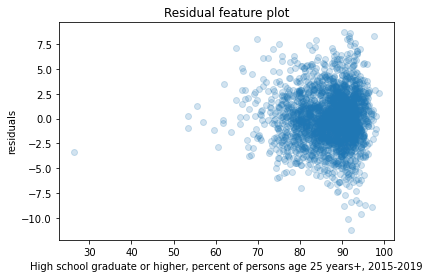

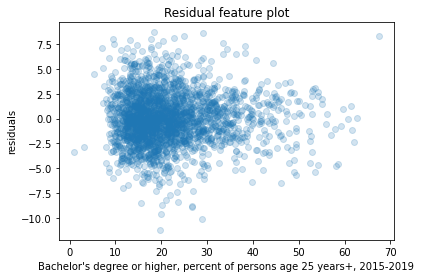

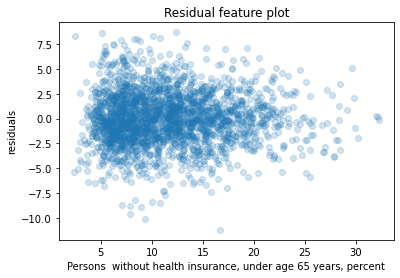

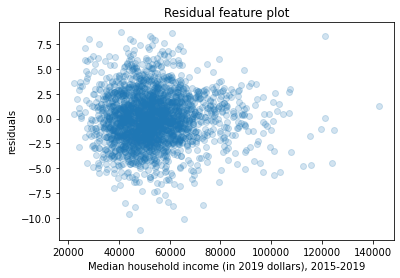

In [10]:
rg.doSimpleLinearRegression(X,y, input_features)

Poly scores:  [0.283, 0.321, 0.339, 0.315, 0.316] 

Poly mean cv r^2: 0.315 +- 0.018


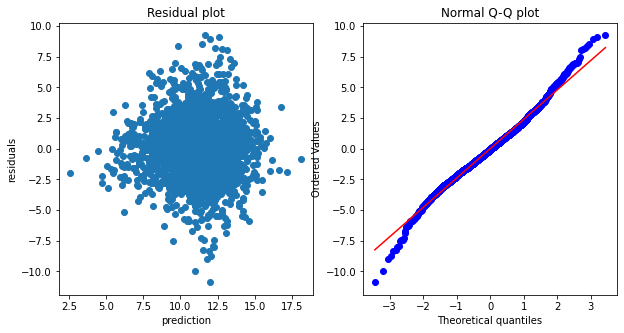

In [11]:
rg.doPolynomialRegression(X,y, input_features)

In [12]:
#rg.doLassoRegression(X,y,10)